# Environment Setup

In [1]:
! pip install pytrends

In [2]:
# library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import time

from pytrends.request import TrendReq
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# allow multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [4]:
# storage location
data_dir = "/content/drive/MyDrive/mit/time_series"

In [5]:
# target firm (ticker)
ticker = "TSLA"

# keywords for the target
keywords = [
    "elon musk", "tesla", "tsla",
    "trump", "tariff", "china",
    "electric vehicle", "cybertruck", "byd",
    "s&p", "layoff", "recession"
]

# period of study and frequency
start_date = "2023-01-01"
end_date = "2024-12-31"
study_freq = "daily"
trends_geo = ""

# Loading the Data

## Loading Google Trends Data

In [6]:
# getting google trends data for one keyword
def get_trends_data(keyword, start_date, end_date, freq="daily", geo=""):
    # validating imputed frequency
    valid_freqs = ["daily", "weekly", "monthly", "yearly"]
    if freq not in valid_freqs:
        raise ValueError(f"Invalid frequency. Must be one of {valid_freqs}.")

    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    pytrends = TrendReq(hl='en-US', tz=360)

    # fetching data in chunks
    if (end_date - start_date).days > 270:
        date_ranges = []
        current_start = start_date
        while current_start < end_date:
            current_end = min(current_start + timedelta(days=269), end_date)
            date_ranges.append((current_start, current_end))
            current_start = current_end + timedelta(days=1)

        dfs = []
        for range_start, range_end in date_ranges:
            timeframe = "{} {}".format(
                range_start.strftime("%Y-%m-%d"),
                range_end.strftime("%Y-%m-%d")
            )
            pytrends.build_payload(
                kw_list=[keyword], timeframe=timeframe, geo=geo
            )
            df = pytrends.interest_over_time()
            if freq != "daily":
                df = df.resample({
                    "weekly": "W",
                    "monthly": "M",
                    "yearly": "Y"
                }[freq]).mean()
            if not df.empty:
                dfs.append(df)

        if dfs:
            df = pd.concat(dfs)
            df = df[~df.index.duplicated(keep='first')]
            df = df.sort_index()
            df = df.loc[start_date:end_date]
            df = df.drop(columns=["isPartial"], errors="ignore")
            df.columns = [keyword]
            df[keyword] = df[keyword].astype(int)
            return df
        else:
            return pd.DataFrame()

    else:
        timeframe = "{} {}".format(
            start_date.strftime("%Y-%m-%d"),
            end_date.strftime("%Y-%m-%d")
        )
        pytrends.build_payload(
            kw_list=[keyword], timeframe=timeframe, geo=geo
        )
        df = pytrends.interest_over_time()
        if freq != "daily":
            df = df.resample({
                "weekly": "W",
                "monthly": "M",
                "yearly": "Y"
            }[freq]).mean()
        if not df.empty:
            df = df.drop(columns=["isPartial"], errors="ignore")
            df.columns = [keyword]
            df[keyword] = df[keyword].astype(int)
        return df

In [8]:
# getting trends data for all the keywords
trends_data = {}
i = 0
for keyword in keywords:
    print(f"Getting data for keyword: {keyword}")
    try:
        trends_data[keyword] = get_trends_data(
            keyword=keyword,
            start_date=start_date,
            end_date=end_date,
            freq=study_freq,
            geo=trends_geo
        )
    except:
        print(f"Error getting data for keyword: {keyword}")
        break
    time.sleep(5 + i)
    i += 1

# concatenate dataframes side by side
df_trends = pd.concat(trends_data.values(), axis=1)
df_trends.head()
df_trends.shape

Getting data for keyword: elon musk
Getting data for keyword: tesla
Getting data for keyword: tsla
Getting data for keyword: trump
Getting data for keyword: tariff
Getting data for keyword: china
Getting data for keyword: electric vehicle
Getting data for keyword: cybertruck
Getting data for keyword: byd
Getting data for keyword: s&p
Error getting data for keyword: s&p


,elon musk,tesla,tsla,trump,tariff,china,electric vehicle,cybertruck,byd
date,,,,,,,,,
2023-01-01,98,47,13,8,33,64,57,19,21
2023-01-02,83,55,26,7,44,60,68,20,32
2023-01-03,64,72,95,7,64,57,75,20,33
2023-01-04,57,74,78,7,70,57,74,24,33
2023-01-05,54,64,58,8,73,59,75,22,39


(731, 9)

In [18]:
df_trends = df_trends_copy.copy()
df_trends.head()
df_trends.shape

,elon musk,tesla,tsla,trump,tariff,china,electric vehicle,cybertruck,byd
date,,,,,,,,,
2023-01-01,98,47,13,8,33,64,57,19,21
2023-01-02,83,55,26,7,44,60,68,20,32
2023-01-03,64,72,95,7,64,57,75,20,33
2023-01-04,57,74,78,7,70,57,74,24,33
2023-01-05,54,64,58,8,73,59,75,22,39


(731, 9)

In [12]:
df_aapl = pd.read_csv("/content/drive/MyDrive/mit/time_series/AAPL_daily_20230101_20241231.csv")
df_aapl.index = pd.to_datetime(df_aapl["date"])
df_aapl = df_aapl.drop(columns=["date"])
df_aapl.head()
df_aapl.shape

,tim cook,apple,aapl,trump,tariff,china,iphone,samsung,macbook,s&p,layoff,recession,price,r,volume
date,,,,,,,,,,,,,,,
2023-01-01,10,50,6,8,33,67,47,84,72,22,7,35,NaN,NaN,NaN
2023-01-02,10,51,11,7,43,62,46,91,81,38,9,59,NaN,NaN,NaN
2023-01-03,8,48,49,7,64,59,42,81,85,68,15,69,NaN,NaN,NaN
2023-01-04,8,48,47,7,70,59,43,83,85,64,25,66,124.907715,0.010262,89113600.0
2023-01-05,7,47,37,8,72,59,43,81,90,60,57,66,123.583115,-0.010661,80962700.0


(731, 15)

In [20]:
# merge df_trends and df_aapl
for keyword in keywords:
  if keyword in df_aapl.columns:
    df_trends[keyword] = df_aapl[keyword]
df_trends.head()
df_trends.shape

,elon musk,tesla,tsla,trump,tariff,china,electric vehicle,cybertruck,byd,s&p,layoff,recession
date,,,,,,,,,,,,
2023-01-01,98,47,13,8,33,67,57,19,21,22,7,35
2023-01-02,83,55,26,7,43,62,68,20,32,38,9,59
2023-01-03,64,72,95,7,64,59,75,20,33,68,15,69
2023-01-04,57,74,78,7,70,59,74,24,33,64,25,66
2023-01-05,54,64,58,8,72,59,75,22,39,60,57,66


(731, 12)

## Loading Stock Returns Data

In [21]:
# fetching raw yfinance pricing data for the ticker
def get_stock_data(ticker, start_date, end_date, freq="daily"):
    freq_map = {
        "daily": "1d",
        "weekly": "1wk",
        "monthly": "1mo",
        "yearly": "1y"
    }
    if freq not in freq_map:
        raise ValueError("Invalid frequency. Must be one of {}.".format(
            ", ".join(freq_map.keys())
        ))

    df = yf.download(
        ticker,
        start=start_date, end=end_date,
        interval=freq_map[freq],
        progress=True,
        auto_adjust=True
    )
    if df.empty:
        df = yf.Ticker(ticker).history(
            start=start_date, end=end_date,
            auto_adjust=True,
            interval=freq_map[freq]
        )

    # rename index Date to date
    df.index.name = "date"

    return df

# process the data to get log returns
def process_stock_data(df, price_type="Close"):
    df["price"] = df[price_type]
    df["volume"] = df["Volume"]
    df["r"] = np.log(df[price_type] / df[price_type].shift(1))
    df = df[["price", "r", "volume"]]
    df = df.dropna()
    return df

In [33]:
df_ticker = pd.read_csv(
    "{}/tsla_nasdaq_extract.csv".format(
        data_dir
    )
)
df_ticker.head()
df_ticker.shape

# remove $ sign from columns and convert to numeric
df_ticker["Open"] = df_ticker["Open"].str.replace("$", "").astype(float)
df_ticker["High"] = df_ticker["High"].str.replace("$", "").astype(float)
df_ticker["Low"] = df_ticker["Low"].str.replace("$", "").astype(float)
df_ticker["Close"] = df_ticker["Close/Last"].str.replace("$", "").astype(float)
df_ticker["Volume"] = df_ticker["Volume"].astype(float)

df_ticker["date"] = pd.to_datetime(df_ticker["Date"])
df_ticker.index = df_ticker["date"]
df_ticker.head()
df_ticker.shape

df_ticker = df_ticker[["Open", "High", "Low", "Close", "Volume"]]
df_ticker.head()
df_ticker.shape

df_ticker = process_stock_data(df_ticker)
df_ticker = df_ticker.loc[
    (df_ticker.index >= start_date) &\
    (df_ticker.index <= end_date)
]
df_ticker.sort_index(inplace=True)
df_ticker.head()
df_ticker.shape

,Date,Close/Last,Volume,Open,High,Low
0,05/07/2025,$276.22,71882410,$276.88,$277.92,$271.00
1,05/06/2025,$275.35,76715790,$273.105,$277.73,$271.35
2,05/05/2025,$280.26,94618880,$284.57,$284.849,$274.40
3,05/02/2025,$287.21,114454700,$284.90,$294.78,$279.81
4,05/01/2025,$280.52,99658970,$280.01,$290.8688,$279.81


(1256, 6)

,Date,Close/Last,Volume,Open,High,Low,Close,date
date,,,,,,,,
2025-05-07,05/07/2025,$276.22,71882410.0,276.880,277.9200,271.00,276.22,2025-05-07
2025-05-06,05/06/2025,$275.35,76715790.0,273.105,277.7300,271.35,275.35,2025-05-06
2025-05-05,05/05/2025,$280.26,94618880.0,284.570,284.8490,274.40,280.26,2025-05-05
2025-05-02,05/02/2025,$287.21,114454700.0,284.900,294.7800,279.81,287.21,2025-05-02
2025-05-01,05/01/2025,$280.52,99658970.0,280.010,290.8688,279.81,280.52,2025-05-01


(1256, 8)

,Open,High,Low,Close,Volume
date,,,,,
2025-05-07,276.880,277.9200,271.00,276.22,71882410.0
2025-05-06,273.105,277.7300,271.35,275.35,76715790.0
2025-05-05,284.570,284.8490,274.40,280.26,94618880.0
2025-05-02,284.900,294.7800,279.81,287.21,114454700.0
2025-05-01,280.010,290.8688,279.81,280.52,99658970.0


(1256, 5)

,price,r,volume
date,,,
2023-01-03,108.10,-0.049979,231402800.0
2023-01-04,113.64,0.029469,180389000.0
2023-01-05,110.34,-0.024352,157986300.0
2023-01-06,113.06,-0.057655,220911100.0
2023-01-09,119.77,0.007711,190284000.0


(502, 3)

In [24]:
# getting prices, volumes, and log returns for the stock
df_ticker = get_stock_data(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    freq=study_freq
)
df_ticker = process_stock_data(df_ticker)
df_ticker.head()
df_ticker.tail()
df_ticker.shape

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GOOG']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

In [34]:
# merging gtrends and ticker data
df = pd.concat([df_trends, df_ticker], axis=1)
df.columns = [
    col[0] if isinstance(col, tuple) else col
    for col in df.columns
]
df.head()
df.tail()
df.shape

,elon musk,tesla,tsla,trump,tariff,china,electric vehicle,cybertruck,byd,s&p,layoff,recession,price,r,volume
date,,,,,,,,,,,,,,,
2023-01-01,98,47,13,8,33,67,57,19,21,22,7,35,NaN,NaN,NaN
2023-01-02,83,55,26,7,43,62,68,20,32,38,9,59,NaN,NaN,NaN
2023-01-03,64,72,95,7,64,59,75,20,33,68,15,69,108.10,-0.049979,231402800.0
2023-01-04,57,74,78,7,70,59,74,24,33,64,25,66,113.64,0.029469,180389000.0
2023-01-05,54,64,58,8,72,59,75,22,39,60,57,66,110.34,-0.024352,157986300.0


,elon musk,tesla,tsla,trump,tariff,china,electric vehicle,cybertruck,byd,s&p,layoff,recession,price,r,volume
date,,,,,,,,,,,,,,,
2024-12-27,32,57,34,2,18,36,57,60,94,31,29,6,431.66,0.033569,82666820.0
2024-12-28,38,50,10,2,14,33,63,65,87,17,32,5,NaN,NaN,NaN
2024-12-29,39,49,7,2,11,34,56,68,82,15,26,5,NaN,NaN,NaN
2024-12-30,27,52,33,2,17,35,56,59,74,35,36,6,417.41,0.033050,64941010.0
2024-12-31,31,53,33,2,17,40,55,60,66,32,34,6,403.84,0.062744,76825120.0


(731, 15)

In [35]:
# write to gdrive
file_path = "{}/{}_{}_{}_{}.csv".format(
    data_dir, ticker, study_freq,
    start_date.replace("-", ""), end_date.replace("-", "")
)
df.to_csv(file_path)

# Descriptive Statistics

In [36]:
# utility for plotting ccf
def plot_two_way_ccf(series1, series2, title='Cross-Correlation', max_lag=30):
    # align and drop nan
    df = pd.concat([series1, series2], axis=1).dropna()
    x = df.iloc[:,0]
    y = df.iloc[:,1]

    # ccf calculation in both directions
    ccf_pos = ccf(x, y, adjusted=False)[:max_lag+1]
    ccf_neg = ccf(y, x, adjusted=False)[:max_lag+1]

    # combine negative and positive lags
    ccf_neg_reversed = ccf_neg[::-1][:-1]
    ccf_combined = np.concatenate([ccf_neg_reversed, ccf_pos])
    lags = np.arange(-max_lag, max_lag+1)

    # plot
    fig, ax = plt.subplots(figsize=(14, 6))
    markerline, stemlines, baseline = ax.stem(lags, ccf_combined, basefmt=' ')
    plt.setp(stemlines, color='steelblue', linewidth=1.5)
    plt.setp(markerline, color='darkblue', markersize=7)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    conf_int = 2/np.sqrt(len(x))
    ax.axhline(y=conf_int, color='red', linestyle='--', linewidth=0.8)
    ax.axhline(y=-conf_int, color='red', linestyle='--', linewidth=0.8)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_title(
        f'{title}\n(Series1: {series1.name} vs Series2: {series2.name})',
        pad=20
    )
    ax.set_xlabel('Lag (Series 1 leads to the right of 0)', fontsize=12)
    ax.set_ylabel('Cross-Correlation Coefficient', fontsize=12)
    ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.5)

    # highlight significant correlations
    sig_points = np.where(np.abs(ccf_combined) > conf_int)[0]
    for point in sig_points:
        ax.annotate(f'{ccf_combined[point]:.2f}',
                    xy=(lags[point], ccf_combined[point]),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center', va='bottom',
                    color='red' if ccf_combined[point] > 0 else 'darkred',
                    fontsize=9)

    plt.tight_layout()
    plt.show()

    # return results as DataFrame
    results = pd.DataFrame({
        'Lag': lags,
        'Correlation': ccf_combined,
        'Significant': np.abs(ccf_combined) > conf_int
    })

    return results

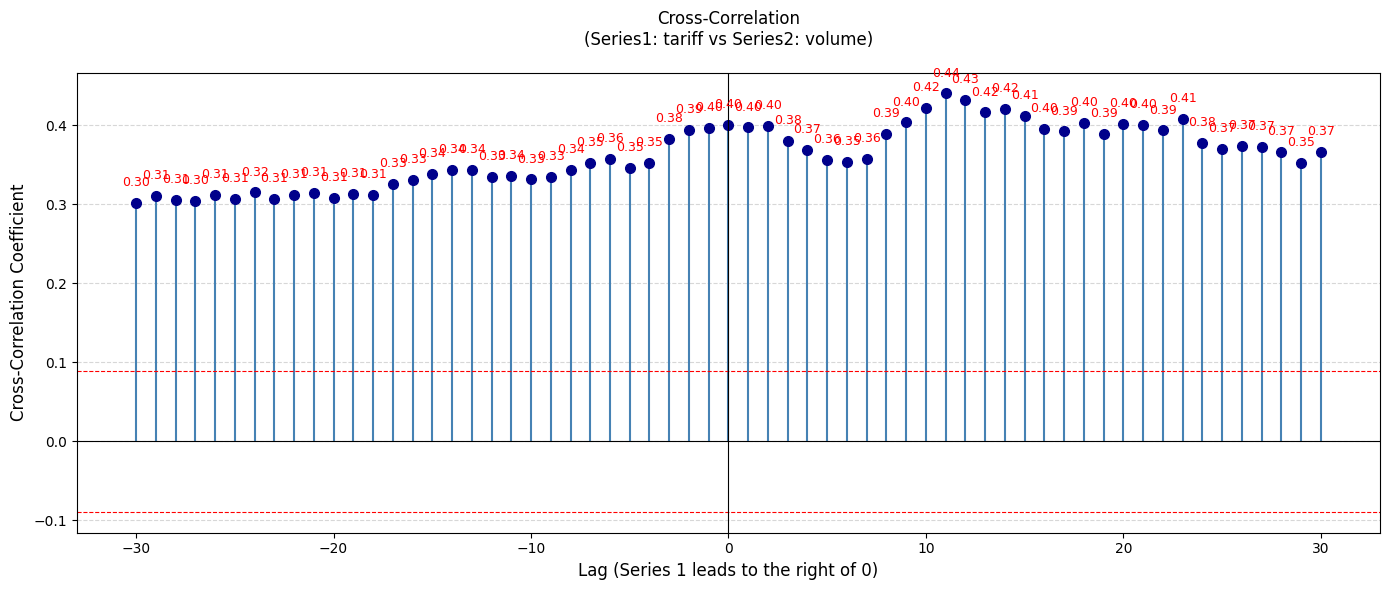

,Lag,Correlation,Significant
0,-30,0.301819,True
1,-29,0.310190,True
2,-28,0.305909,True
3,-27,0.304716,True
4,-26,0.311766,True
...,...,...,...
56,26,0.373452,True
57,27,0.373119,True
58,28,0.366080,True
59,29,0.352768,True


In [37]:
# plotting each ccf of each keyword against

plot_two_way_ccf(df["tariff"], df["volume"])

# Analysis/Models from Hanson's Notebook

Text(0.5, 1.0, 'elon musk')

Text(0.5, 1.0, 'tesla')

Text(0.5, 1.0, 'tsla')

Text(0.5, 1.0, 'trump')

Text(0.5, 1.0, 'tariff')

Text(0.5, 1.0, 'china')

Text(0.5, 1.0, 'electric vehicle')

Text(0.5, 1.0, 'cybertruck')

Text(0.5, 1.0, 'byd')

Text(0.5, 1.0, 's&p')

Text(0.5, 1.0, 'layoff')

Text(0.5, 1.0, 'recession')

Text(0.5, 1.0, 'price')

Text(0.5, 1.0, 'r')

Text(0.5, 1.0, 'volume')

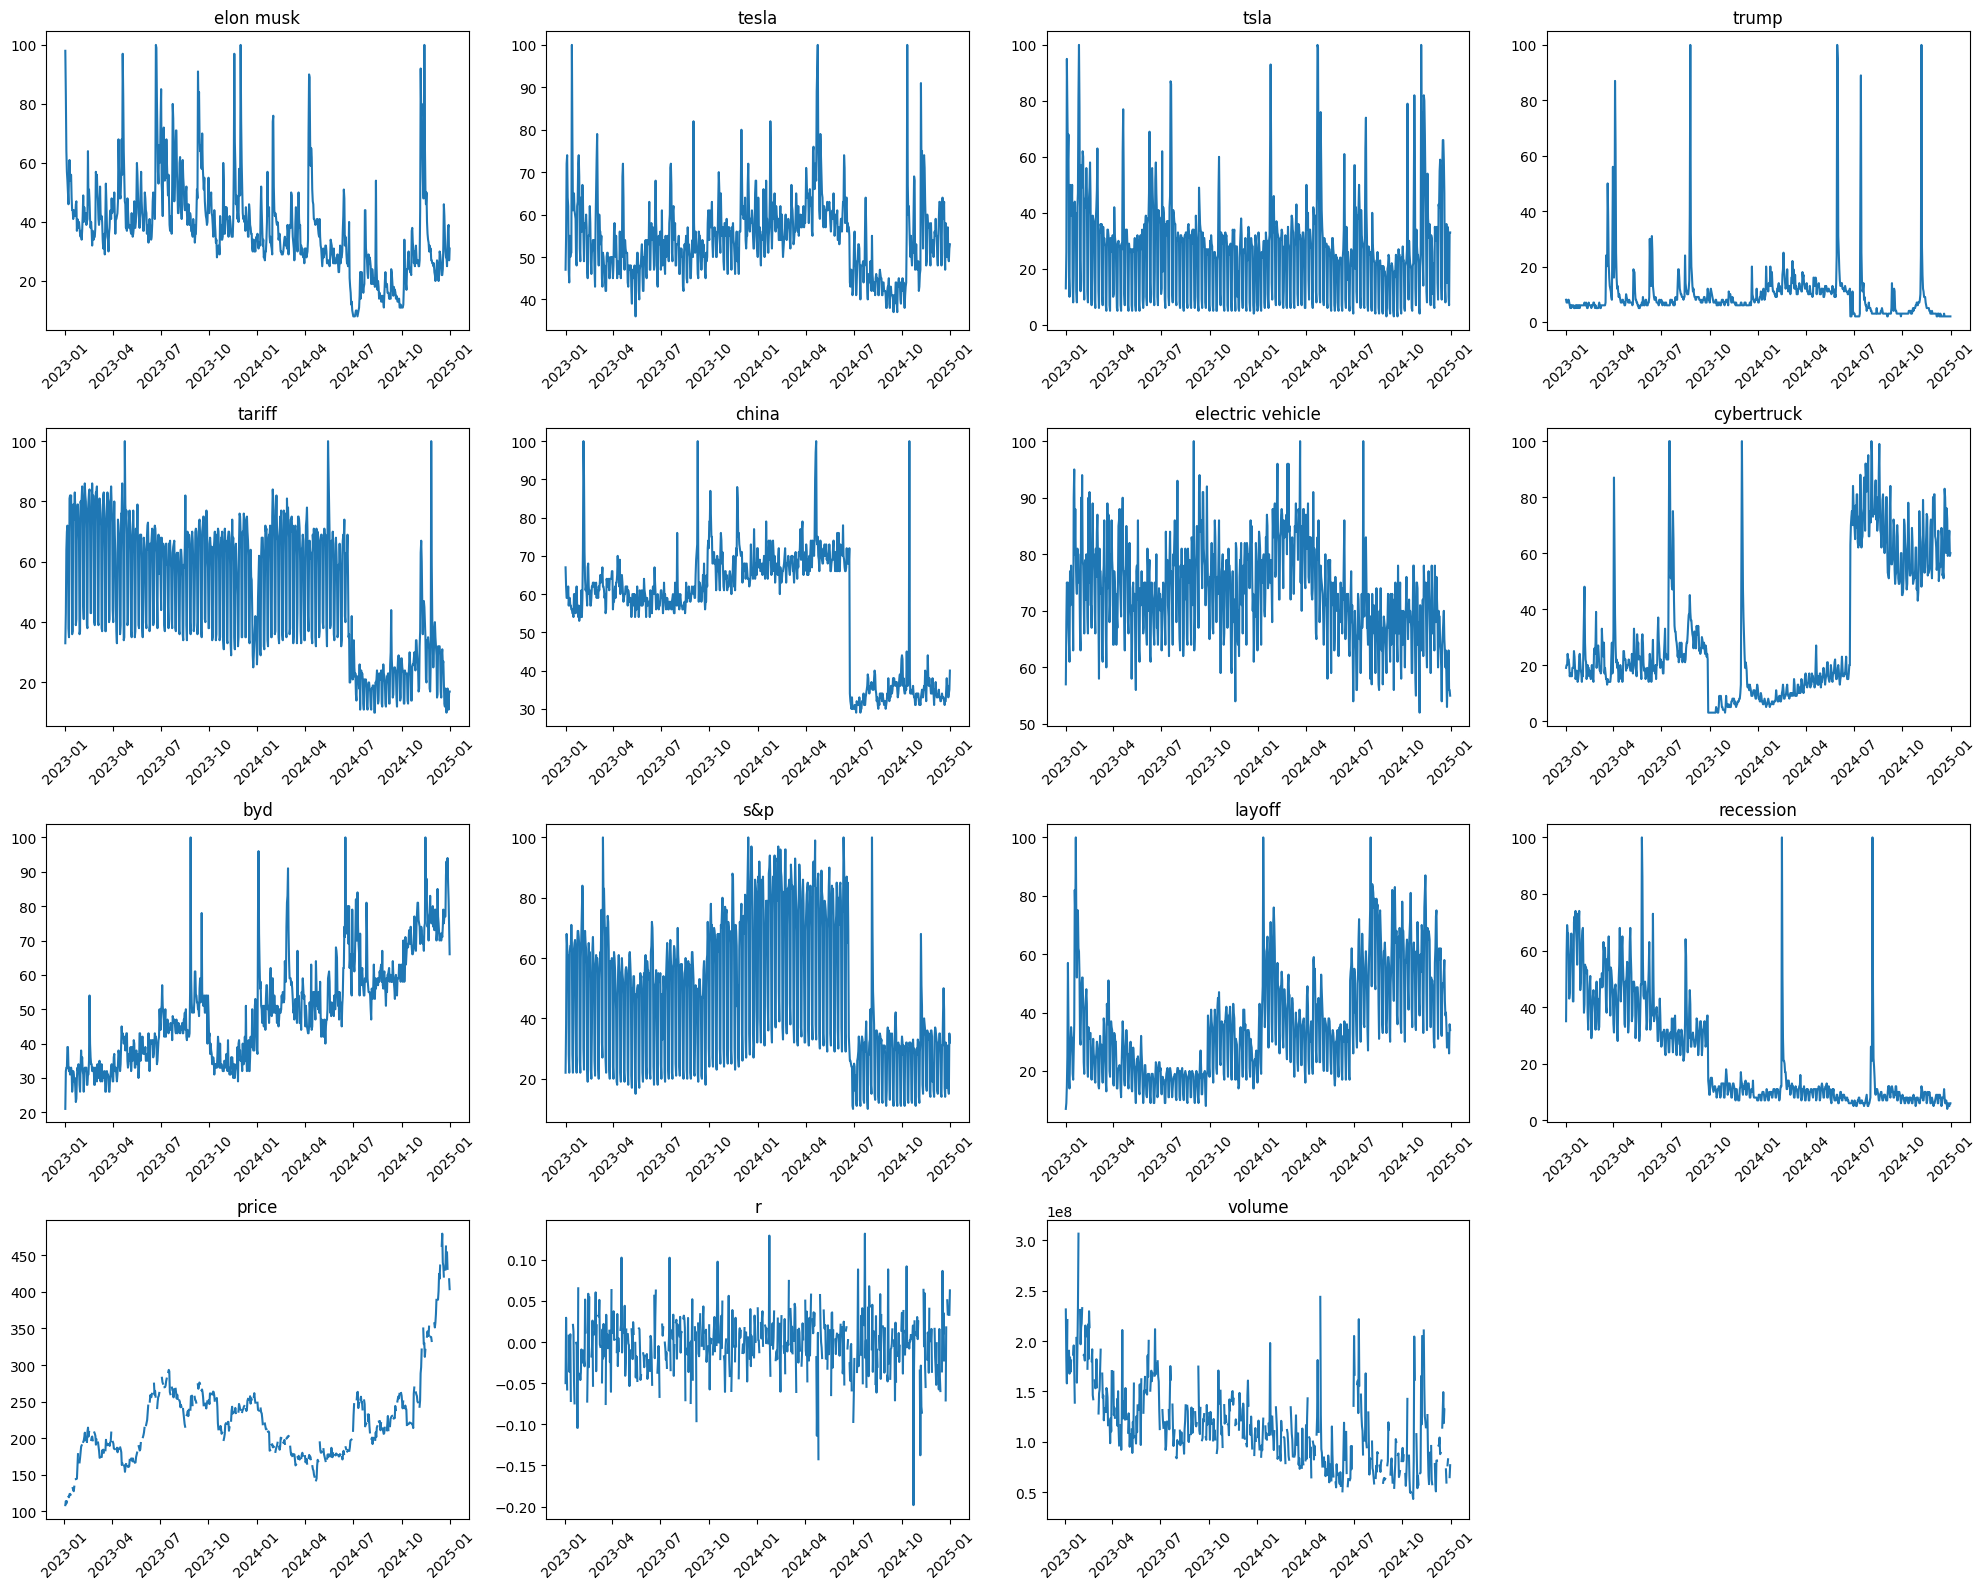

In [38]:
n_cols = 4
n_rows = -(-len(df.columns) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    axes[i].plot(df.index, df[col])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

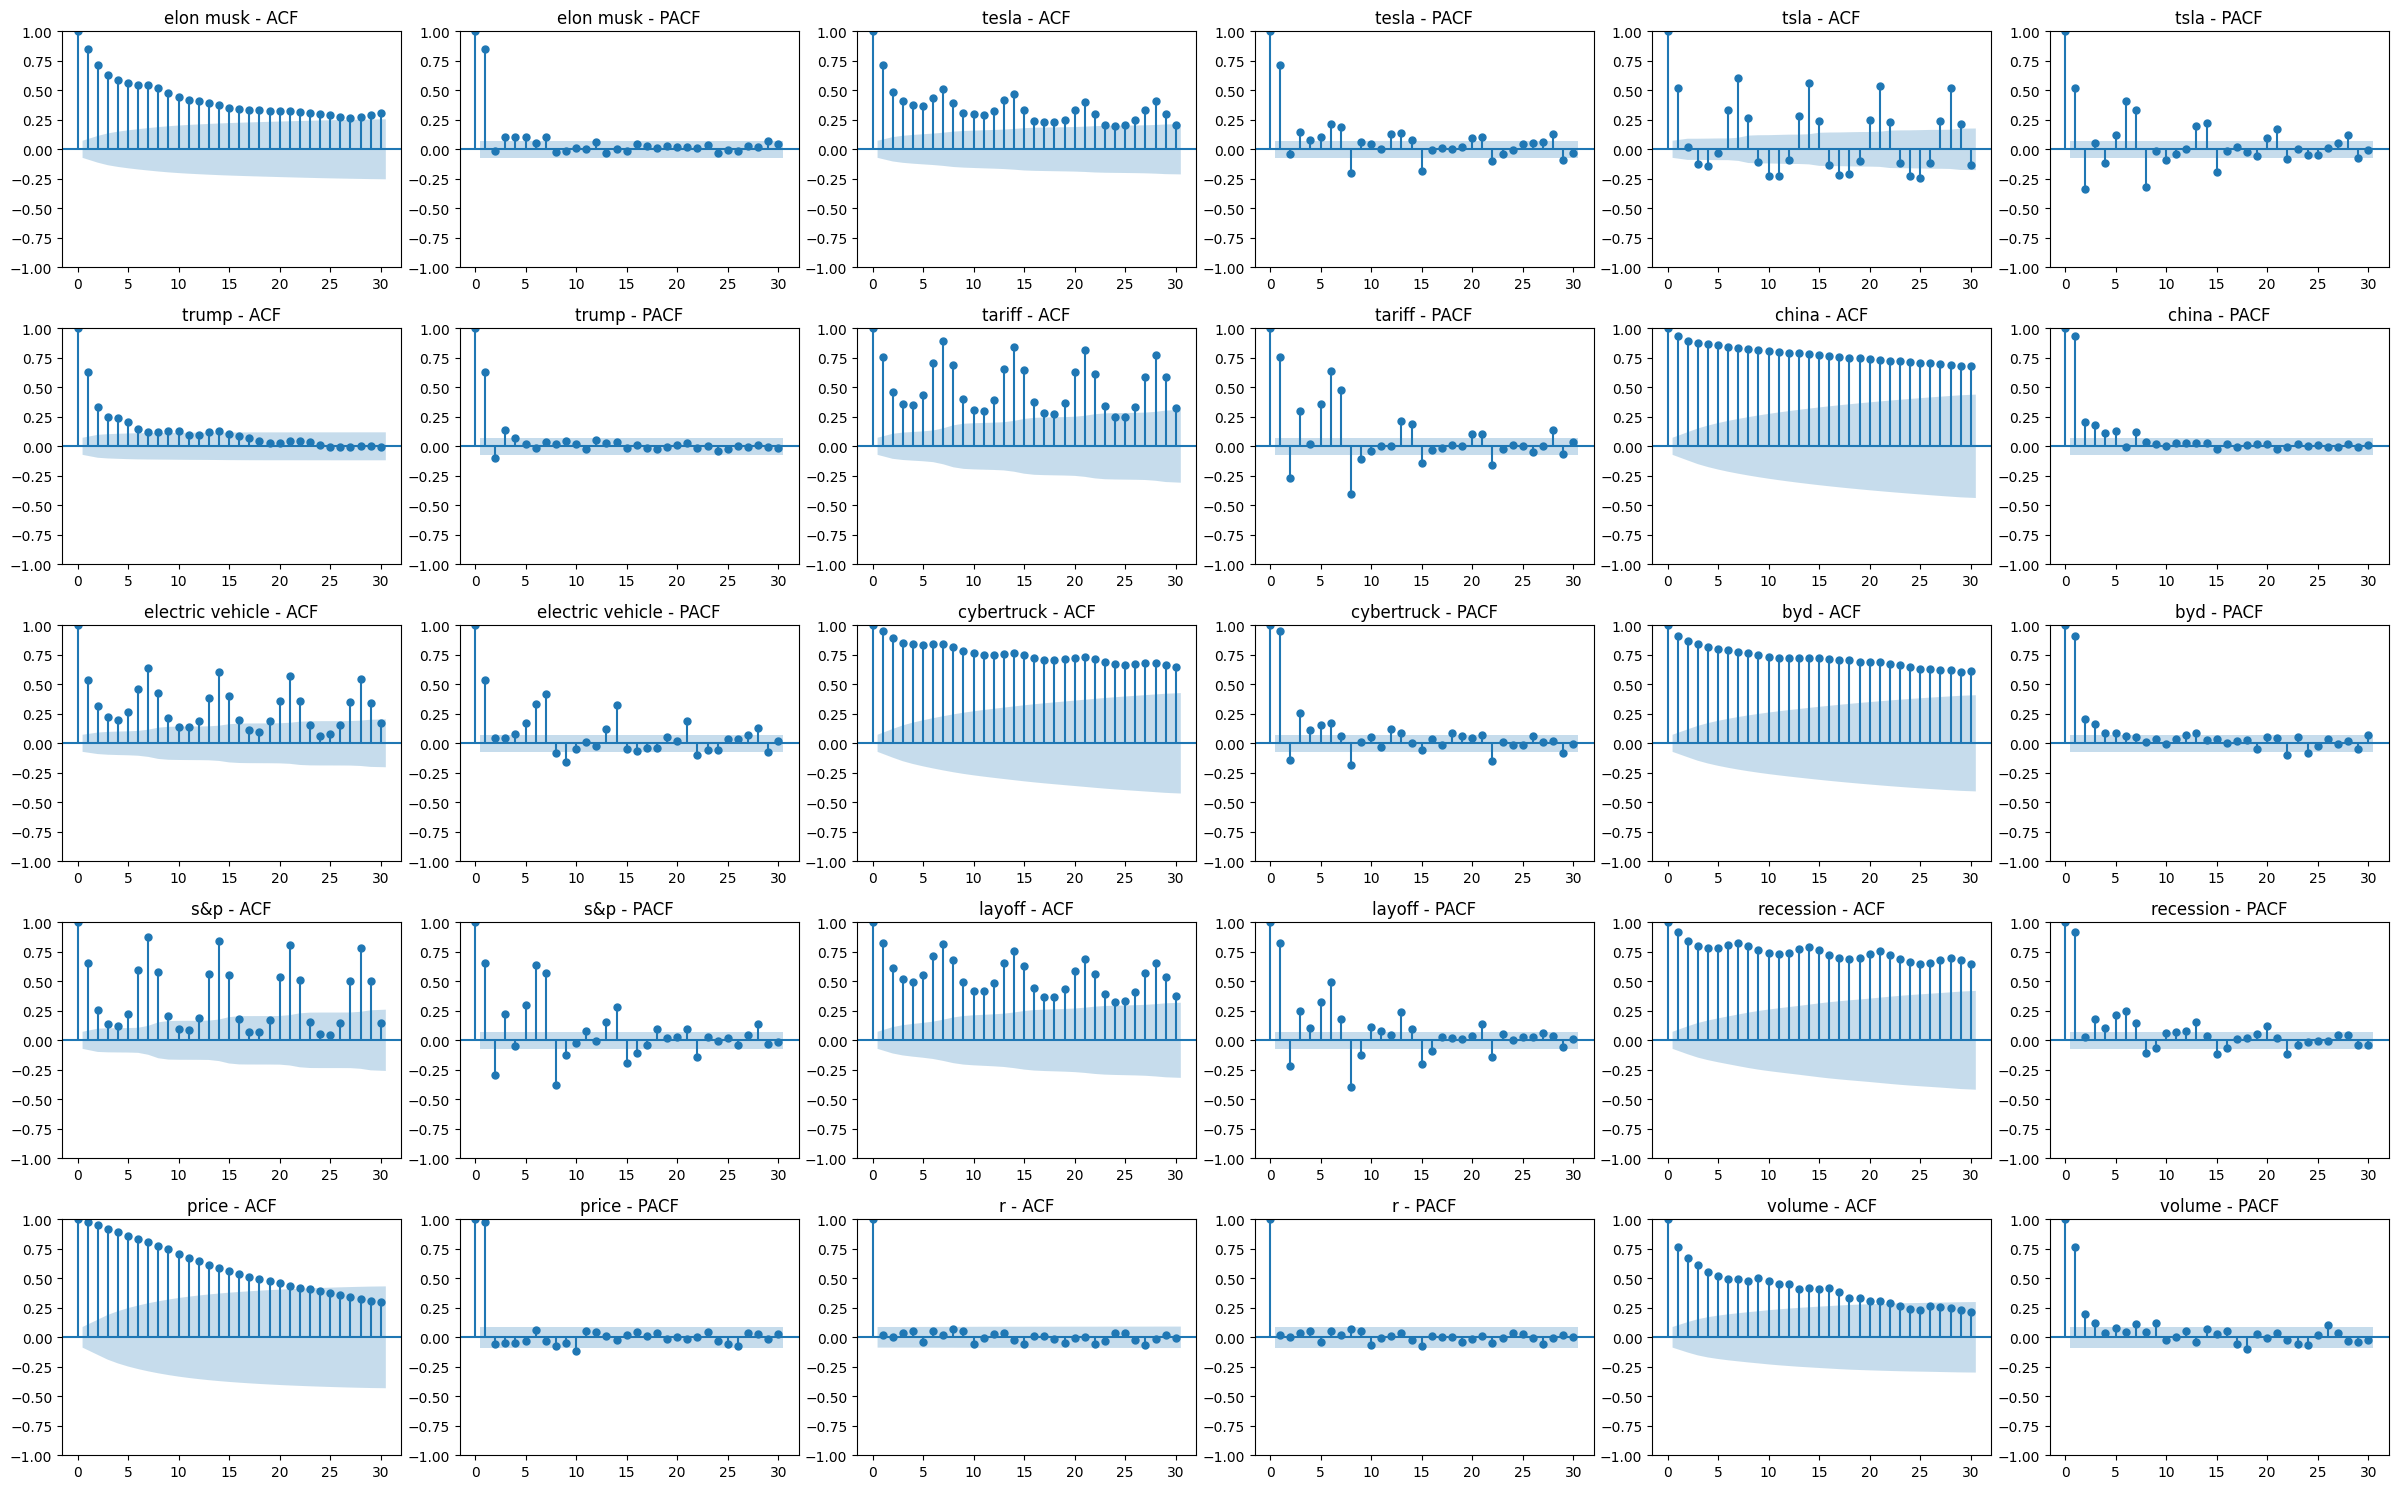

In [39]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math

def plot_all_acf_pacf(df, lags=30, plots_per_row=3):
    num_features = len(df.columns)
    num_pairs = num_features
    n_cols = plots_per_row * 2
    n_rows = math.ceil(num_pairs / plots_per_row)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = axes.reshape(-1, n_cols)

    for i, col in enumerate(df.columns):
        row_idx = i // plots_per_row
        col_acf = (i % plots_per_row) * 2
        col_pacf = col_acf + 1

        series = df[col].dropna().values

        plot_acf(series, lags=lags, ax=axes[row_idx, col_acf])
        axes[row_idx, col_acf].set_title(f"{col} - ACF")

        plot_pacf(series, lags=lags, ax=axes[row_idx, col_pacf])
        axes[row_idx, col_pacf].set_title(f"{col} - PACF")

    total_subplots = n_rows * n_cols
    for j in range(2 * num_features, total_subplots):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()
plot_all_acf_pacf(df, lags=30, plots_per_row=3)

In [40]:
def plot_two_way_ccf(series1, series2, title='Cross-Correlation', max_lag=30):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from statsmodels.tsa.stattools import ccf

    # align and drop nan
    df = pd.concat([series1, series2], axis=1).dropna()
    x = df.iloc[:, 0]
    y = df.iloc[:, 1]

    # ccf calculation in both directions
    ccf_pos = ccf(x, y, adjusted=False)[:max_lag + 1]
    ccf_neg = ccf(y, x, adjusted=False)[:max_lag + 1]

    # combine lags
    ccf_combined = np.concatenate([ccf_neg[::-1][:-1], ccf_pos])
    lags = np.arange(-max_lag, max_lag + 1)
    conf_int = 2 / np.sqrt(len(x))

    # plot
    fig, ax = plt.subplots(figsize=(9, 3))
    markerline, stemlines, baseline = ax.stem(lags, ccf_combined, basefmt=' ')
    plt.setp(stemlines, color='steelblue', linewidth=1)
    plt.setp(markerline, color='darkblue', markersize=4)
    ax.axhline(0, color='black', linewidth=0.7)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.7)
    ax.axhline(y=conf_int, color='red', linestyle='--', linewidth=0.7)
    ax.axhline(y=-conf_int, color='red', linestyle='--', linewidth=0.7)
    ax.set_title(f'{title}\n({series1.name} vs {series2.name})', fontsize=11)
    ax.set_xlabel('Lag', fontsize=9)
    ax.set_ylabel('Corr.', fontsize=9)
    ax.tick_params(axis='both', labelsize=8)
    ax.grid(True, linestyle='--', alpha=0.3)

    # Annotate significant points
    for lag, corr in zip(lags, ccf_combined):
        if abs(corr) > conf_int:
            ax.annotate(f'{corr:.2f}', xy=(lag, corr), xytext=(0, 6),
                        textcoords='offset points', ha='center',
                        fontsize=7, color='crimson')

    plt.tight_layout()
    plt.show()

    return pd.DataFrame({
        'Lag': lags,
        'Correlation': ccf_combined,
        'Significant': np.abs(ccf_combined) > conf_int
    })

Plotting ccf for keyword: elon musk


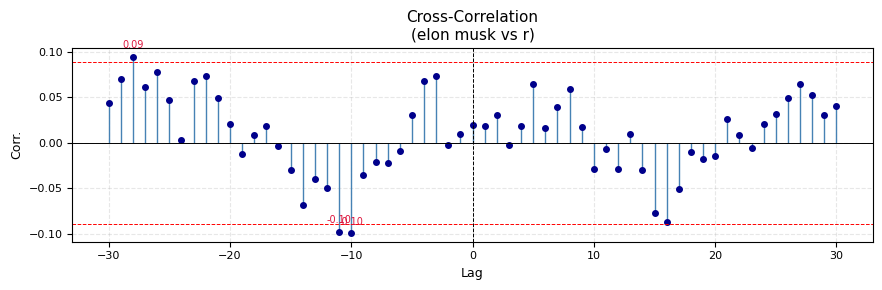

,Lag,Correlation,Significant
0,-30,0.043821,False
1,-29,0.070550,False
2,-28,0.094905,True
3,-27,0.061565,False
4,-26,0.077787,False
...,...,...,...
56,26,0.049422,False
57,27,0.064983,False
58,28,0.052935,False
59,29,0.030908,False


Plotting ccf for keyword: tesla


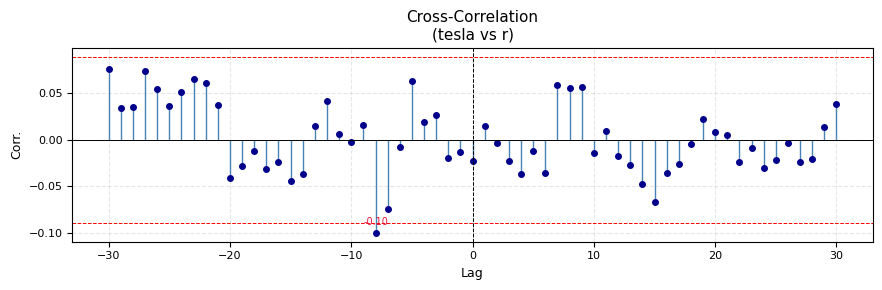

,Lag,Correlation,Significant
0,-30,0.076435,False
1,-29,0.034551,False
2,-28,0.035550,False
3,-27,0.073822,False
4,-26,0.054947,False
...,...,...,...
56,26,-0.003704,False
57,27,-0.024327,False
58,28,-0.020133,False
59,29,0.013793,False


Plotting ccf for keyword: tsla


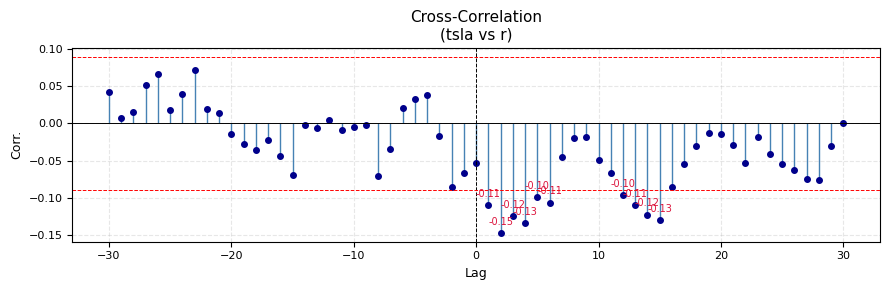

,Lag,Correlation,Significant
0,-30,0.042466,False
1,-29,0.006821,False
2,-28,0.014790,False
3,-27,0.051477,False
4,-26,0.065538,False
...,...,...,...
56,26,-0.062171,False
57,27,-0.074280,False
58,28,-0.075982,False
59,29,-0.030265,False


Plotting ccf for keyword: trump


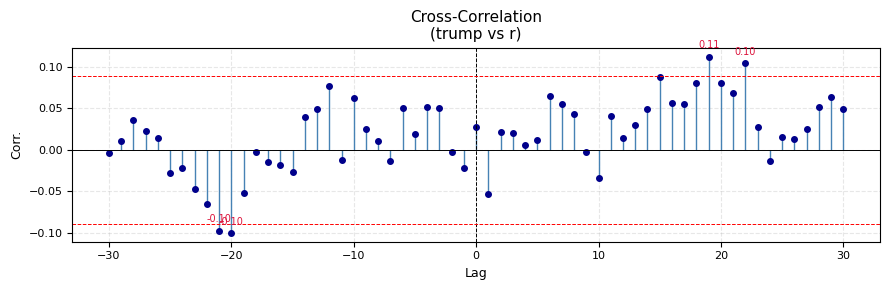

,Lag,Correlation,Significant
0,-30,-0.004709,False
1,-29,0.010350,False
2,-28,0.035442,False
3,-27,0.022541,False
4,-26,0.013930,False
...,...,...,...
56,26,0.012917,False
57,27,0.024791,False
58,28,0.050952,False
59,29,0.062940,False


Plotting ccf for keyword: tariff


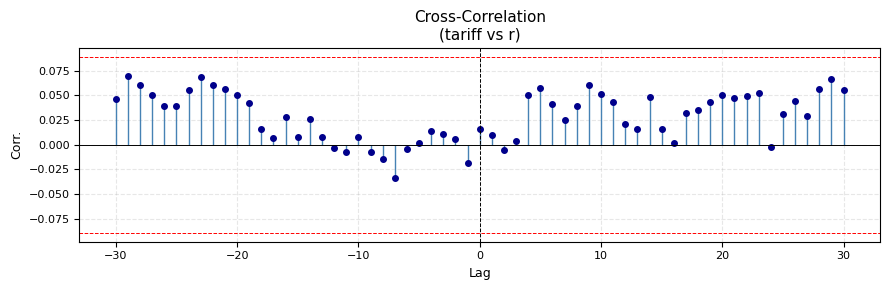

,Lag,Correlation,Significant
0,-30,0.046093,False
1,-29,0.069606,False
2,-28,0.060494,False
3,-27,0.050555,False
4,-26,0.039323,False
...,...,...,...
56,26,0.044138,False
57,27,0.029201,False
58,28,0.055951,False
59,29,0.066921,False


Plotting ccf for keyword: china


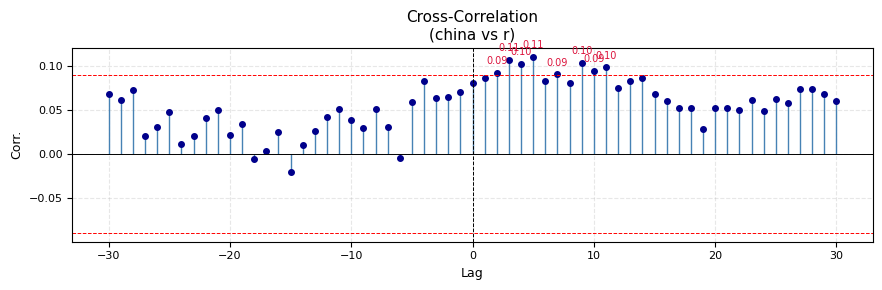

,Lag,Correlation,Significant
0,-30,0.068388,False
1,-29,0.061077,False
2,-28,0.072214,False
3,-27,0.020398,False
4,-26,0.030823,False
...,...,...,...
56,26,0.058056,False
57,27,0.072933,False
58,28,0.073755,False
59,29,0.067671,False


Plotting ccf for keyword: electric vehicle


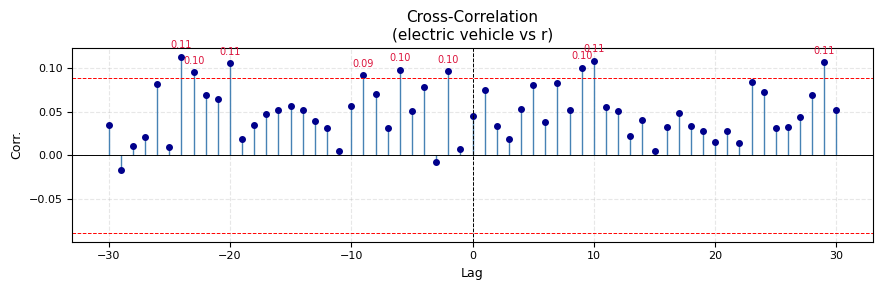

,Lag,Correlation,Significant
0,-30,0.034915,False
1,-29,-0.016486,False
2,-28,0.010538,False
3,-27,0.021163,False
4,-26,0.082053,False
...,...,...,...
56,26,0.032796,False
57,27,0.044657,False
58,28,0.069981,False
59,29,0.107059,True


Plotting ccf for keyword: cybertruck


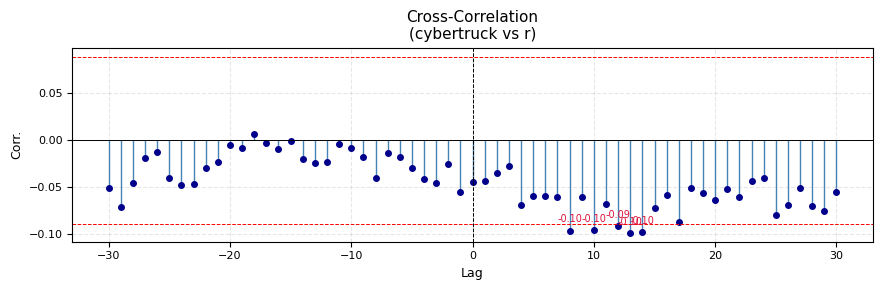

,Lag,Correlation,Significant
0,-30,-0.051192,False
1,-29,-0.071524,False
2,-28,-0.044971,False
3,-27,-0.019075,False
4,-26,-0.012544,False
...,...,...,...
56,26,-0.068771,False
57,27,-0.050373,False
58,28,-0.069660,False
59,29,-0.075832,False


Plotting ccf for keyword: byd


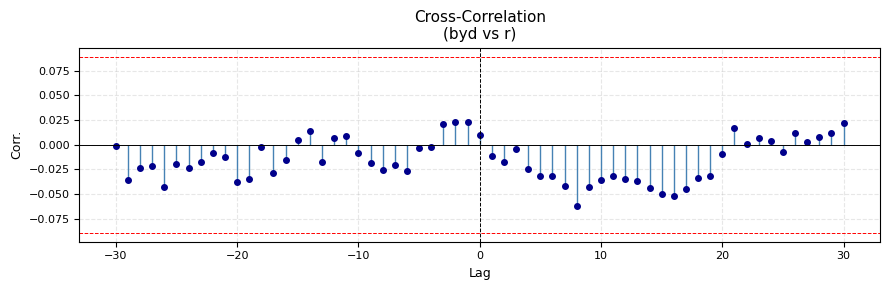

,Lag,Correlation,Significant
0,-30,-0.001773,False
1,-29,-0.035294,False
2,-28,-0.023685,False
3,-27,-0.021370,False
4,-26,-0.043053,False
...,...,...,...
56,26,0.011530,False
57,27,0.003068,False
58,28,0.007705,False
59,29,0.011953,False


Plotting ccf for keyword: s&p


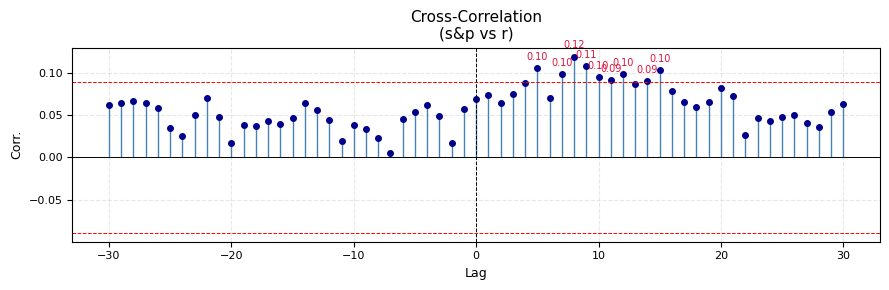

,Lag,Correlation,Significant
0,-30,0.062071,False
1,-29,0.063598,False
2,-28,0.066029,False
3,-27,0.064470,False
4,-26,0.058372,False
...,...,...,...
56,26,0.049813,False
57,27,0.040362,False
58,28,0.036121,False
59,29,0.053072,False


Plotting ccf for keyword: layoff


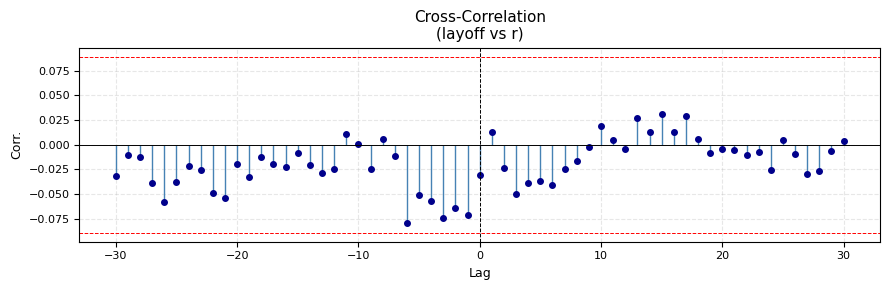

,Lag,Correlation,Significant
0,-30,-0.032023,False
1,-29,-0.010762,False
2,-28,-0.012486,False
3,-27,-0.038532,False
4,-26,-0.058115,False
...,...,...,...
56,26,-0.009389,False
57,27,-0.029198,False
58,28,-0.026311,False
59,29,-0.006628,False


Plotting ccf for keyword: recession


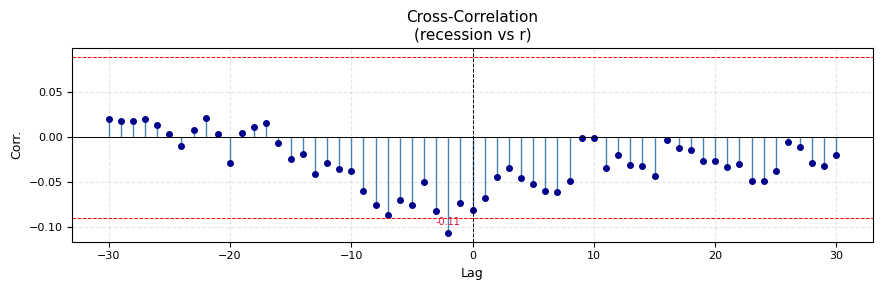

,Lag,Correlation,Significant
0,-30,0.020063,False
1,-29,0.018075,False
2,-28,0.018286,False
3,-27,0.020535,False
4,-26,0.013865,False
...,...,...,...
56,26,-0.005948,False
57,27,-0.011425,False
58,28,-0.028239,False
59,29,-0.032096,False


In [41]:
# plotting each ccf of each keyword against returns
for keyword in keywords:
    print(f"Plotting ccf for keyword: {keyword}")
    plot_two_way_ccf(df[keyword], df["r"])
    plt.show()

Plotting ccf for keyword: elon musk


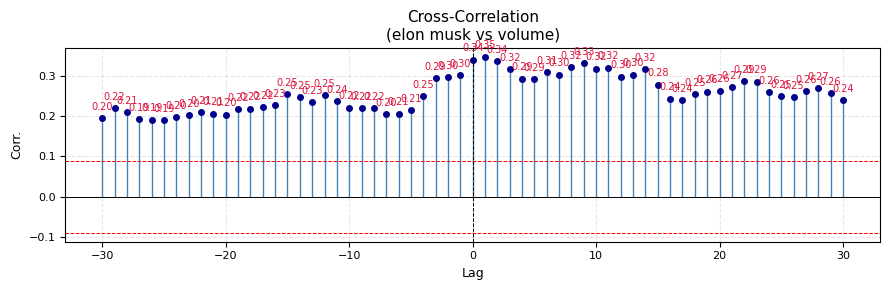

,Lag,Correlation,Significant
0,-30,0.195260,True
1,-29,0.218902,True
2,-28,0.209123,True
3,-27,0.192364,True
4,-26,0.191468,True
...,...,...,...
56,26,0.247610,True
57,27,0.261508,True
58,28,0.269272,True
59,29,0.257319,True


Plotting ccf for keyword: tesla


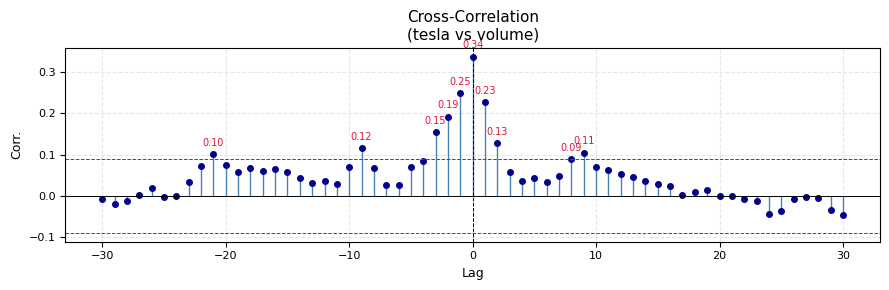

,Lag,Correlation,Significant
0,-30,-0.006785,False
1,-29,-0.020084,False
2,-28,-0.013017,False
3,-27,0.002184,False
4,-26,0.018759,False
...,...,...,...
56,26,-0.006077,False
57,27,-0.001837,False
58,28,-0.004845,False
59,29,-0.033417,False


Plotting ccf for keyword: tsla


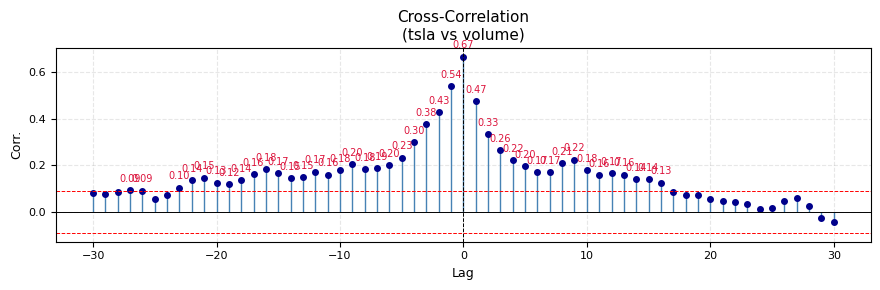

,Lag,Correlation,Significant
0,-30,0.079407,False
1,-29,0.076095,False
2,-28,0.084004,False
3,-27,0.094602,True
4,-26,0.091102,True
...,...,...,...
56,26,0.049136,False
57,27,0.061311,False
58,28,0.026128,False
59,29,-0.023524,False


Plotting ccf for keyword: trump


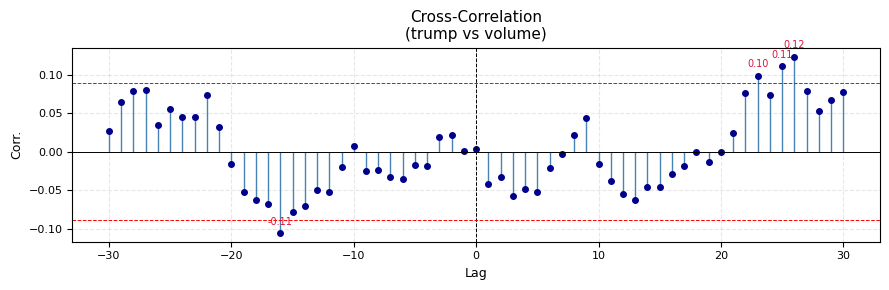

,Lag,Correlation,Significant
0,-30,0.026373,False
1,-29,0.064639,False
2,-28,0.079023,False
3,-27,0.080806,False
4,-26,0.035093,False
...,...,...,...
56,26,0.123659,True
57,27,0.079068,False
58,28,0.052944,False
59,29,0.067808,False


Plotting ccf for keyword: tariff


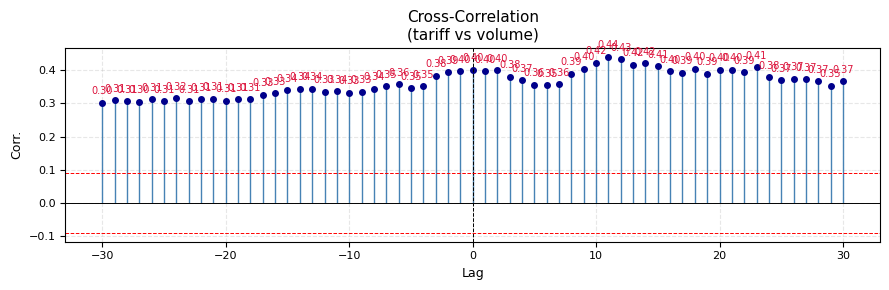

,Lag,Correlation,Significant
0,-30,0.301819,True
1,-29,0.310190,True
2,-28,0.305909,True
3,-27,0.304716,True
4,-26,0.311766,True
...,...,...,...
56,26,0.373452,True
57,27,0.373119,True
58,28,0.366080,True
59,29,0.352768,True


Plotting ccf for keyword: china


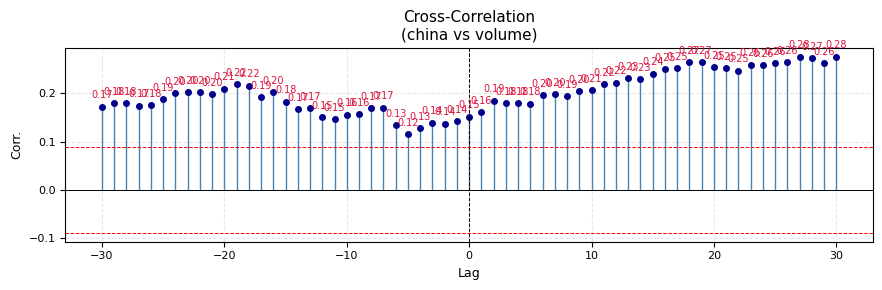

,Lag,Correlation,Significant
0,-30,0.172812,True
1,-29,0.180415,True
2,-28,0.180491,True
3,-27,0.174532,True
4,-26,0.175978,True
...,...,...,...
56,26,0.264934,True
57,27,0.276586,True
58,28,0.272688,True
59,29,0.263261,True


Plotting ccf for keyword: electric vehicle


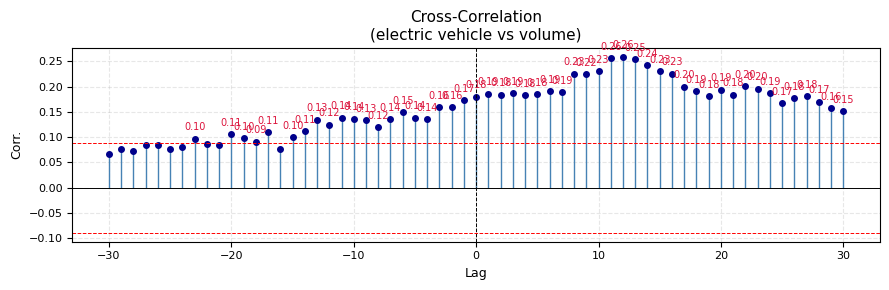

,Lag,Correlation,Significant
0,-30,0.067150,False
1,-29,0.075969,False
2,-28,0.072550,False
3,-27,0.084952,False
4,-26,0.084444,False
...,...,...,...
56,26,0.177408,True
57,27,0.181082,True
58,28,0.169752,True
59,29,0.157697,True


Plotting ccf for keyword: cybertruck


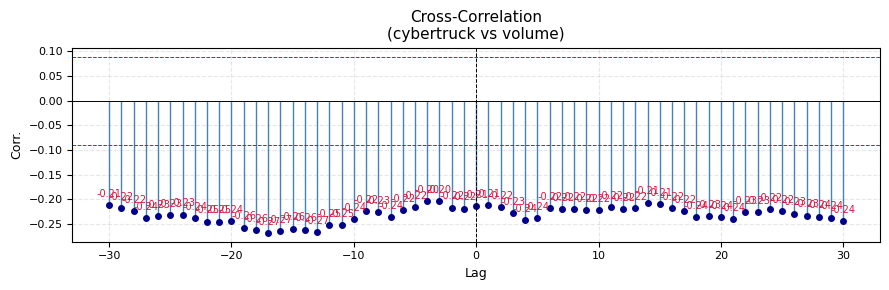

,Lag,Correlation,Significant
0,-30,-0.211533,True
1,-29,-0.217601,True
2,-28,-0.223638,True
3,-27,-0.237974,True
4,-26,-0.234159,True
...,...,...,...
56,26,-0.228992,True
57,27,-0.232669,True
58,28,-0.235143,True
59,29,-0.236790,True


Plotting ccf for keyword: byd


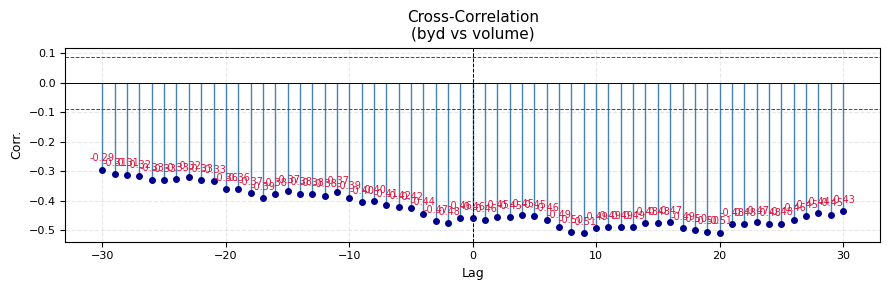

,Lag,Correlation,Significant
0,-30,-0.293697,True
1,-29,-0.309806,True
2,-28,-0.310746,True
3,-27,-0.316249,True
4,-26,-0.327914,True
...,...,...,...
56,26,-0.463034,True
57,27,-0.451875,True
58,28,-0.441835,True
59,29,-0.446384,True


Plotting ccf for keyword: s&p


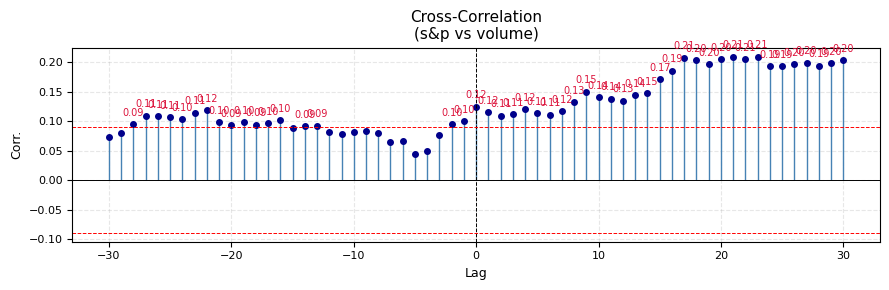

,Lag,Correlation,Significant
0,-30,0.073521,False
1,-29,0.079289,False
2,-28,0.094960,True
3,-27,0.108893,True
4,-26,0.107908,True
...,...,...,...
56,26,0.196876,True
57,27,0.198893,True
58,28,0.193600,True
59,29,0.198239,True


Plotting ccf for keyword: layoff


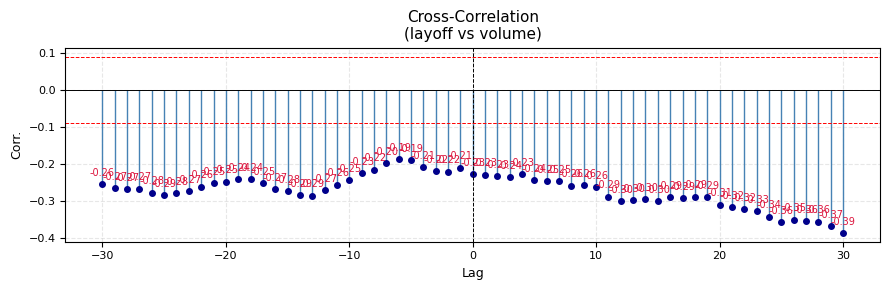

,Lag,Correlation,Significant
0,-30,-0.256310,True
1,-29,-0.267031,True
2,-28,-0.268308,True
3,-27,-0.267434,True
4,-26,-0.278658,True
...,...,...,...
56,26,-0.351845,True
57,27,-0.355076,True
58,28,-0.357141,True
59,29,-0.369453,True


Plotting ccf for keyword: recession


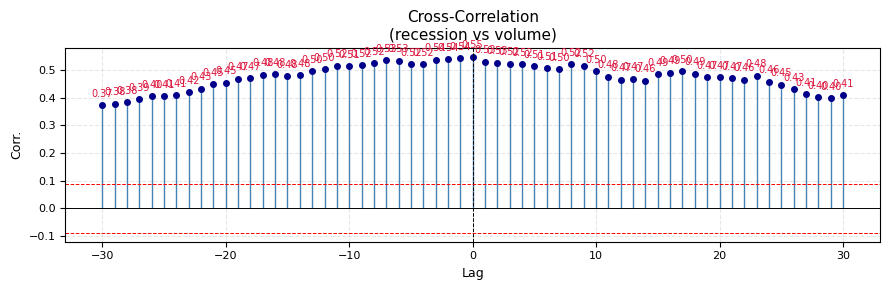

,Lag,Correlation,Significant
0,-30,0.372135,True
1,-29,0.377689,True
2,-28,0.384295,True
3,-27,0.393782,True
4,-26,0.404950,True
...,...,...,...
56,26,0.430456,True
57,27,0.411617,True
58,28,0.402677,True
59,29,0.398858,True


In [42]:
# plotting each ccf of each keyword against volume
for keyword in keywords:
    print(f"Plotting ccf for keyword: {keyword}")
    plot_two_way_ccf(df[keyword], df["volume"])
    plt.show()

In [43]:
df['is_trading_day'] = df['price'].notna().astype(int)

df['price'] = df['price'].ffill()

df['r'] = df['r'].fillna(0)
df['volume'] = df['volume'].fillna(0)
keyword_cols = keywords  # might have to change this with some feature selection!

for col in keyword_cols:
    df[f'{col}_interaction'] = df[col] * df['is_trading_day']

df['volatility'] = df['r'].rolling(window=5).std()
model_df = df[['r', 'volume', 'volatility'] + keyword_cols +
              [f'{col}_interaction' for col in keyword_cols] +
              ['is_trading_day']].dropna()
df = df.dropna()
model_df = model_df.dropna()
model_df.head()

,r,volume,volatility,elon musk,tesla,tsla,trump,tariff,china,electric vehicle,...,trump_interaction,tariff_interaction,china_interaction,electric vehicle_interaction,cybertruck_interaction,byd_interaction,s&p_interaction,layoff_interaction,recession_interaction,is_trading_day
date,,,,,,,,,,,,,,,,,,,,,
2023-01-05,-0.024352,157986300.0,0.029820,54,64,58,8,72,59,75,...,8,72,59,75,22,39,60,57,66,1
2023-01-06,-0.057655,220911100.0,0.035991,50,62,68,8,66,62,67,...,8,66,62,67,22,39,61,36,58,1
2023-01-07,0.000000,0.0,0.035991,46,47,17,7,38,57,64,...,0,0,0,0,0,0,0,0,0,0
2023-01-08,0.000000,0.0,0.032533,56,44,10,6,35,59,61,...,0,0,0,0,0,0,0,0,0,0
2023-01-09,0.007711,190284000.0,0.026798,61,55,50,5,81,59,77,...,5,81,59,77,17,33,62,25,56,1


In [44]:
from statsmodels.tsa.statespace.varmax import VARMAX

endog_vars = ['r', 'volume', 'volatility']
exog_vars = keyword_cols + [f'{col}_interaction' for col in keyword_cols] + ['is_trading_day']

model = VARMAX(model_df[endog_vars], exog=model_df[exog_vars], order=(1, 0))
results = model.fit(disp=False)

print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:     ['r', 'volume', 'volatility']   No. Observations:                  727
Model:                                   VARX(1)   Log Likelihood               -9963.807
                                     + intercept   AIC                          20113.614
Date:                           Thu, 08 May 2025   BIC                          20540.385
Time:                                   22:08:25   HQIC                         20278.297
Sample:                               01-05-2023                                         
                                    - 12-31-2024                                         
Covariance Type:                             opg                                         
Ljung-Box (L1) (Q):       0.12, 3.32, 5.99   Jarque-Bera (JB):   727.18, 84.27, 1225.63
Prob(Q):                  0.72, 0.07, 0.01   Prob(JB):                 0.00, 0.00, 0.00
Heteroskedasti

In [45]:
import warnings
warnings.filterwarnings("ignore")

results_dict = []

for p in range(1, 4):
    for q in range(0, 2):
        try:
            model = VARMAX(model_df[endog_vars], exog=model_df[exog_vars], order=(p, q))
            res = model.fit(disp=False)
            results_dict.append({
                'p': p,
                'q': q,
                'aic': res.aic,
                'bic': res.bic
            })
            print(f"Fitted VARMAX({p},{q}) - AIC: {res.aic:.2f}, BIC: {res.bic:.2f}")
        except Exception as e:
            print(f"Failed to fit VARMAX({p},{q}): {e}")

Fitted VARMAX(1,0) - AIC: 20113.61, BIC: 20540.38
Failed to fit VARMAX(1,1): 2-th leading minor of the array is not positive definite
Fitted VARMAX(2,0) - AIC: 20576.18, BIC: 21044.25
Fitted VARMAX(2,1) - AIC: 140299822684.29, BIC: 140299823193.66
Failed to fit VARMAX(3,0): Schur decomposition solver error.
Failed to fit VARMAX(3,1): Schur decomposition solver error.


In [46]:
from statsmodels.stats.diagnostic import acorr_ljungbox

resid_df = results.resid.dropna()

for col in resid_df.columns:
    print(f"\nLjung-Box test for residual of '{col}':")
    lb_test = acorr_ljungbox(resid_df[col], lags=[10], return_df=True)
    print(lb_test)


Ljung-Box test for residual of 'r':
     lb_stat  lb_pvalue
10  8.180431   0.611218

Ljung-Box test for residual of 'volume':
       lb_stat     lb_pvalue
10  382.484941  5.008498e-76

Ljung-Box test for residual of 'volatility':
      lb_stat     lb_pvalue
10  85.416504  4.320049e-14


In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_volume = SARIMAX(
    endog=model_df['volume'],
    exog=model_df[keyword_cols + [f'{col}_interaction' for col in keyword_cols] + ['is_trading_day']],
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_volume = model_volume.fit(disp=False)
print(results_volume.summary())

                               SARIMAX Results                                
Dep. Variable:                 volume   No. Observations:                  727
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -13108.214
Date:                Thu, 08 May 2025   AIC                          26272.428
Time:                        22:11:43   BIC                          26400.841
Sample:                    01-05-2023   HQIC                         26321.987
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
elon musk                     2.957e-07   1.83e+05   1.61e-12      1.000   -3.59e+05    3.59e+05
tesla                         2.082e-06   1.61e+05   1.29e-11      1.000   -3

In [48]:
resid = results_volume.resid
print(acorr_ljungbox(resid, lags=[10], return_df=True))

      lb_stat  lb_pvalue
10  35.404099   0.000107


In [49]:
! pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 17.4 MB/s eta 0:00:00


In [50]:
from arch import arch_model


returns = model_df['r'].dropna()
garch_model = arch_model(returns, vol='GARCH', p=1, q=1, mean='Zero')  # 或 mean='AR'
garch_result = garch_model.fit(disp='off')
print(garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      r   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                1515.51
Distribution:                  Normal   AIC:                          -3025.02
Method:            Maximum Likelihood   BIC:                          -3011.25
                                        No. Observations:                  727
Date:                Thu, May 08 2025   Df Residuals:                      727
Time:                        22:12:04   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.8246e-05  1.255e-11  1.453e+06      0.000 

In [51]:
resid = garch_result.resid / garch_result.conditional_volatility
print(acorr_ljungbox(resid, lags=[10], return_df=True))

      lb_stat  lb_pvalue
10  10.235801   0.420055
